
# Float vertical position control, realistic float behavior


---

## Equations of motion

Equations governing the float behavior are taken from P. Lherminier thesis (Annex 3, [link](https://tel.archives-ouvertes.fr/tel-00881646)):
which is strongly inspired from Voorhis (1971) (link).
They may account for water motions.
We ignore rotational dynamics which is less relevant when the float is not equipped with propellers.

Central variables are:
- $z_f$ : float vertical position
- $z_w$ : water vertical position
- $z_r=z_w-z_f$: water vertical position with respect to the float position

Corresponding velocities are:
$w_f=\frac{dz_f}{dt}$, $w=\frac{dz_w}{dt}$, $w_r=w-w_f$

The dynamical equation ruling the float vertical displacement is:

$$
\begin{align*}
m \frac{d^2z_f}{dt^2} = m \frac{dw_f}{dt} = \Pi - mg - D,
\end{align*}
$$

where:
- $\Pi$ represents the vertical component induced by pressure forces on the float.
- $D$ is the vertical force exerted by viscous drag forces.

Pressure forces are decomposed into one contribution due to pressure fields in the absence of the float
($\Pi_0$) and one contribution associated with disruptions of the flow by the float ($\Pi'$).

$$
\begin{align*}
\Pi_0 &= -V\partial_z p = -\frac{m}{\rho_f} \partial_z p \\
&= \frac{mg\rho_w}{\rho_f} + m \frac{\rho_w}{\rho_f} \frac{Dw}{Dt}
\end{align*}
$$

where $Dw/Dt$ is the vertical acceleration of water.
Densities are given by the float and water equations of state which may be linearized or not:

$$
\begin{align*}
\rho_w &= \rho_w(p,T,S) \\
\rho_f &= \rho_f(p,T) = \frac{m}{V(T,P)+v}\\
\end{align*}
$$

where $V$ represents the bulk of the float volume that may be affected by pressure and temperature and $v$ is the volume taken in and out by the pump.

For large water motions with respect to float length, disruptions of the pressure field by the float lead to a drag that is proportional to the square of relative velocity:

$$
\begin{align*}
\Pi' &= \frac{m}{L_v} \Big | \frac{dz_r}{dt} \Big | \frac{dz_r}{dt},
\end{align*}
$$

where $L_v$ is a drag lengthscale that is comparable to the length of the float $L_f$.
Not that if water is still: $z_r=-z_f$.

We ignore viscous forces for now.

Assumptions:
- the float follows horizontal motions exactly
- no viscous forces

Additional assumptions made in this notebook: 
- instantaneous thermal equilibrium

---

## Control by integrator chain

Let's reformulate with Luc's notations first ...


The **system state vector** is given by:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
z_f\\
dz_f/dt\\
V+v
\end{array}\right)
\end{align*}
$$

The **control** is given by: $u=\partial_t v$

The **equation of the float evolution** are then:

$$
\begin{align*}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
dz_f/dt\\
d^2z_f/dt^2\\
dV/dt + u
\end{array}\right)
= 
\left(\begin{array}{c} 
x_2\\
f_2(\underline{x})\\
f_3(\underline{x})
\end{array}\right)
+
\left(\begin{array}{c} 
0\\
0\\
u
\end{array}\right)
\end{align*}
$$

The system seems to be **''affine à la commande''**.

where:

$$
\begin{align*}
f_2(\underline{x}) &= \frac{\rho_w(z_f)}{\rho_f} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{dz_r}{dt} \Big | \frac{dz_r}{dt}, \\
&= \frac{\rho_w(z_f)~(V+v)}{m} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{d(z_w-z_f)}{dt} \Big | \frac{d(z_w-z_f)}{dt}, \\
&= \frac{\rho_w(x_1)~x_3}{m} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{dz_w}{dt} - x_2 \Big | \Big ( \frac{dz_w}{dt} - x_2 \Big ), \\
\end{align*}
$$

If we neglect the water vertical acceleration terms and assume water is still:

$$
\begin{align*}
f_2(\underline{x}) &= g\frac{\rho_w(x_1)~x_3}{m} 
- \frac{1}{L_v} \Big | x_2 \Big | x_2 , \\
\end{align*}
$$

As for $f_3$:

$$
\begin{align*}
f_3(\underline{x}) &= \Big ( \partial_p V \frac{dp}{dz} + \partial_T V \frac{dT}{dz} \Big ) \frac{dz_f}{dt}, \\
&= \Big ( \partial_p V \frac{dp}{dz} + \partial_T V \frac{dT}{dz} \Big )(x_1) \times x_2.
\end{align*}
$$

The **observable variable** $y$ is simply $x_1=z_f$.

Let's start now computing **derivatives of $y$**:

$$
\begin{align*}
\frac{dy}{dt} &= \frac{dx_1}{dt} = x_2, \\
\frac{d^2y}{dt^2} &= \frac{dx_2}{dt} = f_2(\underline{x}), \\
\frac{d^3y}{dt^2} &= \frac{df_2(\underline{x})}{dt} 
= \partial_{x_1} f_2 \frac{dx_1}{dt} 
+ \partial_{x_2} f_2 \frac{dx_2}{dt} 
+ \partial_{x_3} f_2 \frac{dx_3}{dt}\\
&= \partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + (f_3+u)\partial_{x_3} f_2
\end{align*}
$$

Let's now choose $v$ (!! different from v in $V+v$ !!) such that:

$$
\begin{align*}
v &= \partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + (f_3+u)\partial_{x_3} f_2.
\end{align*}
$$

which leads to:

$$
\begin{align*}
\frac{d^3y}{dt^2} &= v.
\end{align*}
$$

**Three integrators** applied on $v$ leads to $y$.
$u$ is given by:

$$
\begin{align*}
u &= \frac{\partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + f_3\partial_{x_3} f_2 - v}{\partial_{x_3} f_2}.
\end{align*}
$$

**Singularities** may occur if $\partial_{x_3} f_2=0$.

Sticking to Luc's notation, $u$ can be rewritten as:

$$
\begin{align*}
u &= \frac{d^3y/dt^3 - b(\underline{x})}{a(\underline{x})}.
\end{align*}
$$

Let's search for:

$$
\begin{align*}
\frac{d^3y}{dt^3} = \alpha_0 (y_d - y) 
+ \alpha_1 \frac{d(y_d - y)}{dt} 
+ \alpha_2 \frac{d^2(y_d - y)}{dt^2}
+ \frac{d^3y_d}{dt^3}
\end{align*}
$$

This leads to the following ode for the error:

$$
\begin{align*}
0 = \alpha_0 e
+ \alpha_1 \frac{de}{dt} 
+ \alpha_2 \frac{d^2e^2}{dt^2}
+ \frac{d^3e}{dt^3}
\end{align*}
$$

The natural choice is then: $\alpha_0 = \tau_{ctrl}^{-3}$, $\alpha_1 = 3\tau_{ctrl}^{-2}$, $\alpha_2 = 3\tau_{ctrl}^{-1}$.

The final form of the control is then:

$$
\begin{align*}
u &= \frac{\partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + f_3\partial_{x_3} f_2 - \tau_{ctrl}^{-3} (y_d - y) 
- 3\tau_{ctrl}^{-2} \frac{d(y_d - y)}{dt} 
- 3\tau_{ctrl}^{-1} \frac{d^2(y_d - y)}{dt^2}
- \frac{d^3y_d}{dt^3}}{\partial_{x_3} f_2}.
\end{align*}
$$

An **alternative** with **sliding mode**, we start by defining:

$$
\begin{align*}
s(x,t) = \alpha_0 (y_d - y) 
+ \alpha_1 \frac{d(y_d - y)}{dt} 
+ \frac{d^2(y_d - y)}{dt^2}
\end{align*}
$$

** !! What are $\alpha$ in that case ?  !!**

We would like $s$ to stay close to $0$.
To do that, we can choose:

$$
\begin{align*}
u= \frac{d^3 y}{dt^3} = K \mathrm{sign} [ s(x,t) ]
\end{align*}
$$

$K$ is positive and corresponds to an invert time scale ($K=1/\tau_{ctrl}$ ?).



<!--- We're searching for a second order control:
$$
\begin{align}
\frac{d^2e}{dt^2}+\alpha_1 \frac{de}{dt}+ \alpha_0
\end{align}
$$
where $e=z_{target}-z$ is the difference between the desired trajectory and the actual one.
We want the characteristic polynomial of the preceding ODE to look like: 
$(s+\tau_{ctrl}^{-1})^2=s^2+2s/\tau_{ctrl}+1/\tau_{ctrl}^2$
--->

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import time

from matplotlib import animation, rc
from IPython.display import HTML

from netCDF4 import Dataset

import gsw

Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.14 kg     - float radius
  gamma = 2.00e-06 /dbar  - mechanical compressibility
  alpha = 7.00e-05 /dbar  - mechanical compressibility
  temp0 = 1.50e+01 /degC  - reference temperature

Density at the surface = 1000.000000
Density at 1000dbar = 1002.004008
WOA water profile at lon=-50, lat=40


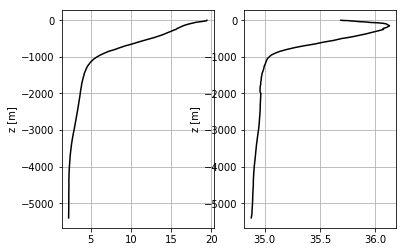

std::bad_cast
std::bad_cast


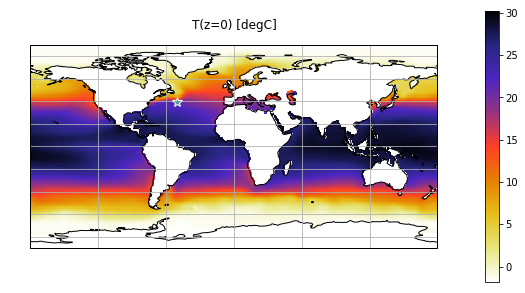

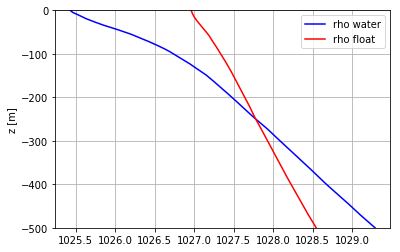

In [2]:

# 
g=9.81

#
def t_modulo_dt(t,dt,threshold):
    if np.abs(t/dt-np.rint(t/dt)) < threshold:
        return True
    else:
        return False

def interp(z_in,v_in,z_out):
    return interp1d(z_in,v_in,kind='linear',fill_value='extrapolate')(z_out)

#
class autonomous_float():
    
    def __init__(self,**kwargs):
        # default parameters
        params = {'a': 0.05, 'L': 0.4, 'gamma': 2.e-6, 'alpha': 7.e-5, 'temp0': 15.}
        params['m']= 1000. * np.pi * params['a']**2 * params['L']
        #
        params.update(kwargs)
        for key,val in params.items():
            setattr(self,key,val)
        # compute the volume of the float:
        self.V = np.pi*self.a**2*self.L

    def __repr__(self):
        strout='Float parameters: \n'
        strout+='  L     = %.2f m      - float length\n'%(self.L)
        strout+='  a     = %.2f m      - float radius\n'%(self.a)
        strout+='  m     = %.2f kg     - float radius\n'%(self.m)
        strout+='  gamma = %.2e /dbar  - mechanical compressibility\n'%(self.gamma)
        strout+='  alpha = %.2e /dbar  - mechanical compressibility\n'%(self.alpha)
        strout+='  temp0 = %.2e /degC  - reference temperature\n'%(self.temp0)
        if hasattr(self,'piston'):
            strout+=str(self.piston)
        return strout
    
    def rho(self,p,temp,v=0.):
        ''' Returns float density i.e. mass over volume
        '''
        return self.m/(self.V*(1.-self.gamma*p+self.alpha*(temp-self.temp0))+v)

    def adjust_balast(self,p_eq,temp_eq,rho_eq):
        ''' Find volume that needs to be added in order to be at equilibrium 
            prescribed pressure, temperature, density
        '''
        v = fsolve(lambda x: rho_eq-self.rho(p_eq,temp_eq,v=x),0.)
        return v

    def adjust_m(self,p_eq,temp_eq,rho_eq):
        ''' Find mass that needs to be added in order to be at equilibrium 
            prescribed pressure, temperature, density
        '''
        def func(m):
            self.m = m
            return rho_eq-self.rho(p_eq,temp_eq)
        m0=self.m
        self.m = fsolve(func,self.m)
        print('%.1f g were added to the float in order to be at equilibrium at %.0f dbar'%((self.m-m0)*1.e3,p_eq))
    
    def time_step(self,waterp,T=600.,dt_step=1.,dt_plt=None,dt_store=60., \
                  z=0.,w=0.,v=None,piston=False,t0=0.,Lv=None, \
                  z_target=0., w_target=0., dwdt_target=0., tau_ctrl=60., dt_ctrl=None, **kwargs):
        ''' Time step the float position given initial conditions
        '''
        t=t0
        self.z = z
        self.w = w
        if piston:
            self.v=self.piston.v
        elif v is None:
            self.v=0.
        else:
            self.v=v
        #
        if Lv is None:
            Lv=self.L
        self.Lv=Lv
        #
        if dt_store is not None:
            threshold_store = 0.5* dt_step/dt_store
        #
        if dt_ctrl is not None:
            threshold_ctrl = 0.5* dt_step/dt_ctrl
        else:
            dt_ctrl = dt_step
            threshold_ctrl = 0.5* dt_step/dt_ctrl
        #
        print('Start time stepping for %d min ...'%(T/60.))
        #
        while t<t0+T:
            #
            p, tempw = waterp.get_p(self.z), waterp.get_temp(self.z)
            rhow = waterp.get_rho(self.z)
            rhof = self.rho(p,tempw,v=self.v)
            # store
            if (dt_store is not None) and t_modulo_dt(t,dt_store,threshold_store):
                ndata = [t,self.z,self.w,rhof,rhow]
                if not hasattr(self,'X'):
                    self.X=np.array(ndata)
                else:
                    self.X=np.vstack((self.X,ndata))
                #print('Data stored at t=%.0f'%t)
                #print('z=%.2f'%self.z)
            # plot
            # get vertical force on float
            _f = self._f(p,rhof,rhow,Lv)            
            # decide wether piston will be adjusted
            if piston and t_modulo_dt(t,dt_ctrl,threshold_ctrl):
                if self._control(self.z,self.w,_f/self.m,z_target,w_target,dwdt_target,tau_ctrl)>0:
                    self.piston.push()
                else:
                    self.piston.pull()
            # update
            self.z += dt_step*self.w
            self.z = np.amin((self.z,0.))
            self.w += dt_step*_f/self.m
            if piston:
                self.v = self.piston.v
            t+=dt_step
        print('... time stepping done')
        
    def _f(self,p,rhof,rhow,Lv):
        ''' Compute the vertical force exterted on the float
        '''
        f = -self.m*g
        f += self.m*rhow/rhof*g # Pi0, we ignore DwDt terms
        f += -self.m/Lv*np.abs(self.w)*self.w # Pi'
        return f
    
    def init_piston(self,vmin,vmax,dv=None,v=None):
        if dv is None:
            dv = (vmax-vmin)/10.
        self.piston = piston(vmin,vmax,dv,v=v)
        
    def _control(self,z,w,dwdt,z_target,w_target,dwdt_target,tau_ctrl):
        ''' Several inputs are required:
        (z_target,w_target,dwdt_target) - describes the trajectory
        tau_ctrl  - a time scale of control 
        '''
        return np.sign( (dwdt_target - dwdt)*tau_ctrl**2 + 2*(w_target-w)*tau_ctrl + z_target-z )
        #return np.sign( z_target-z )

    
class piston():
    
    def __init__(self,vmin,vmax,dv,v=None):
        self.vmin=vmin
        self.vmax=vmax
        self.dv=dv
        if v is None:
            self.v = vmax
        else:
            self.v = v

    def __repr__(self):
        strout='Piston parameters and state: \n'
        strout+='  vmin = %.2f cm^3      - min volume\n'%(self.vmin*1.e6)
        strout+='  vmax = %.2f cm^3      - max volume\n'%(self.vmax*1.e6)
        strout+='  dv   = %.2f cm^3      - volume increments\n'%(self.dv*1.e6)
        strout+='  v    = %.2f cm^3      - present volume addition\n'%(self.v*1.e6)
        return strout
    
    def push(self,dv=None):
        if dv is None:
            self.v+=self.dv
        
    def pull(self,dv=None):
        if dv is None:
            self.v+=-self.dv

#
class waterp():
    
    def __init__(self,lon=None,lat=None):
        if lon is not None and lat is not None:
            self._woa=True
            #
            self._tfile = 'woa13_decav_t00_01v2.nc'
            nc = Dataset(self._tfile,'r')
            #
            glon = nc.variables['lon'][:]
            glat = nc.variables['lat'][:]
            ilon = np.argmin(np.abs(lon-glon))
            ilat = np.argmin(np.abs(lat-glat))
            self.lon = glon[ilon]
            self.lat = glat[ilat]
            #
            self.z = -nc.variables['depth'][:]
            self.p = gsw.p_from_z(self.z,self.lat)
            #
            self.temp = nc.variables['t_an'][0,:,ilat,ilon]
            nc.close()
            #
            self._sfile = 'woa13_decav_s00_01v2.nc'
            nc = Dataset(self._sfile,'r')
            self.s = nc.variables['s_an'][0,:,ilat,ilon]
            nc.close()
            #

    
    def show_on_map(self):
        if self._woa:
            nc = Dataset(self._tfile,'r')
            glon = nc.variables['lon'][:]
            glat = nc.variables['lat'][:]
            temps = nc.variables['t_an'][0,0,:,:]
            nc.close()
            #
            crs=ccrs.PlateCarree()
            plt.figure(figsize=(10, 5))
            ax = plt.axes(projection=crs)
            hdl = ax.pcolormesh(glon,glat,temps,transform = crs,cmap=plt.get_cmap('CMRmap_r'))
            ax.plot(self.lon,self.lat,'*',markersize=10,markerfacecolor='CadetBlue',markeredgecolor='w',transform=crs)
            ax.coastlines(resolution='110m')
            ax.gridlines()
            plt.colorbar(hdl,ax=ax)
            ax.set_title('T(z=0) [degC]')
            plt.show()
    
    def __repr__(self):
        if self._woa:
            strout = 'WOA water profile at lon=%.0f, lat=%.0f'%(self.lon,self.lat)
        ax = plt.subplot(121)
        ax.plot(self.temp,self.z,'k')
        ax.set_ylabel('z [m]')
        plt.grid()
        ax = plt.subplot(122)
        ax.plot(self.s,self.z,'k')
        ax.set_ylabel('z [m]')
        plt.grid()
        return strout

    def get_temp(self,z,eta=0.):
        ''' get in situ temperature
        '''
        return interp(self.z,self.temp,z)

    def get_s(self,z,eta=0.):
        ''' get practical salinity
        '''
        return interp(self.z,self.s,z)

    def get_p(self,z,eta=0.):
        ''' get pressure
        '''
        return interp(self.z,self.p,z)

    def get_theta(self,z,eta=0.):
        ''' get potential temperature
        '''
        pass
    
    def get_rho(self,z,eta=0.):
        s = self.get_s(z,eta=eta)
        p = self.get_p(z,eta=eta)
        SA = gsw.SA_from_SP(s, p, self.lon, self.lat)
        #
        temp = self.get_temp(z,eta=eta)
        CT = gsw.CT_from_t(SA, temp, p)
        #
        return gsw.density.rho(SA, CT, p)
        

#
f = autonomous_float()
print(f)
print('Density at the surface = %f' %f.rho(0.,f.temp0))
print('Density at 1000dbar = %f' %f.rho(1.e3,f.temp0))

#
w = waterp(lon=-50.,lat=40.)
print(w)
w.show_on_map()


# show densities
plt.figure()
ax = plt.subplot(111)
z=np.arange(-500.,0.,1.)
#
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)
iz = np.argmin(np.abs(z+250))
v = f.adjust_balast(p[iz],temp[iz],rho_w[iz])
rho_f=f.rho(p,temp,v=v)
#
ax.plot(rho_w,z,'b',label='rho water')
ax.plot(rho_f,z,'r',label='rho float')
ax.legend()
ax.set_ylim((-500,0.))
ax.set_ylabel('z [m]')
ax.grid()


Start time stepping for 180 min ...
... time stepping done


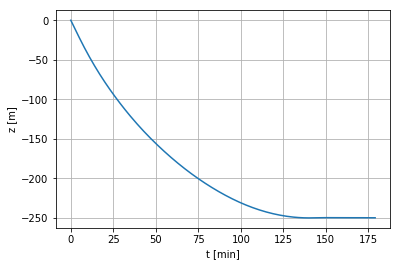

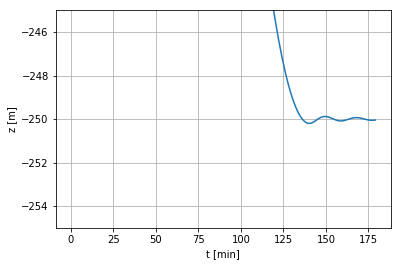

In [3]:
# time step
f.time_step(w,T=3*3600.,dt_step=1.,dt_store=60.,z=0.,w=0.,v=v)

plt.figure()
ax=plt.subplot(111)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()

plt.figure()
ax=plt.subplot(111)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.set_ylim((-255,-245))
ax.grid()



80.9 g were added to the float in order to be at equilibrium at 1 dbar
Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.22 kg     - float radius
  gamma = 2.00e-06 /dbar  - mechanical compressibility
  alpha = 7.00e-05 /dbar  - mechanical compressibility
  temp0 = 1.50e+01 /degC  - reference temperature
Piston parameters and state: 
  vmin = -7.06 cm^3      - min volume
  vmax = 7.06 cm^3      - max volume
  dv   = 0.14 cm^3      - volume increments
  v    = 7.06 cm^3      - present volume addition

Start time stepping for 180 min ...
... time stepping done


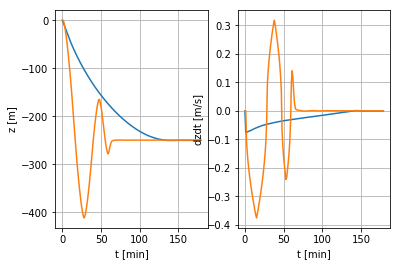

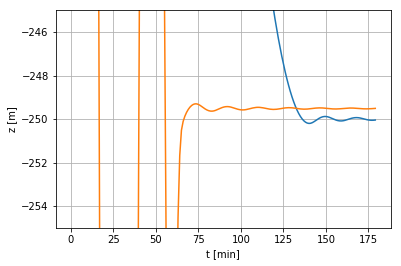

In [4]:
# Init now active control of the vertical position

#
fc = autonomous_float()
# adjust mass to be at equilibrium at -250m
iz = np.argmin(np.abs(z+0))
vmax = fc.adjust_m(p[iz],temp[iz],rho_w[iz])
#
iz = np.argmin(np.abs(z+0))
vmax = fc.adjust_balast(p[iz],temp[iz],rho_w[iz])
# may go down to 
iz = np.argmin(np.abs(z+1000))
vmin = fc.adjust_balast(p[iz],temp[iz],rho_w[iz])
# adjust vmax to be confortable at the surface - arbitrary !!!
vmax = vmax + (vmax-vmin)
# assume 100 increments in volume - arbitrary !!!
dv = (vmax-vmin)/100. # corresponds to 2000m/100 = 20m
#
fc.init_piston(vmin,vmax,dv,v=vmax)
print(fc)

# time step float with control
fc.time_step(w,T=3*3600.,dt_step=1.,dt_store=60.,z=0.,w=0., \
             piston=True,z_target=-250., w_target=0., dwdt_target=0., tau_ctrl=60., dt_ctrl=1.)

plt.figure()
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.plot(fc.X[:,0]/60.,fc.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
#
ax=plt.subplot(122)
ax.plot(f.X[:,0]/60.,f.X[:,2])
ax.plot(fc.X[:,0]/60.,fc.X[:,2])
ax.set_xlabel('t [min]')
ax.set_ylabel('dzdt [m/s]')
ax.grid()

plt.figure()
ax=plt.subplot(111)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.plot(fc.X[:,0]/60.,fc.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.set_ylim((-255,-245))
ax.grid()

---

---

---

---

In [ ]:
    

def draw_float(x, d0=None):
    #time.sleep(0.1)
    #ax = plt.gca()
    plt.cla()
    ax.set_xlim(-ech,ech)
    ax.set_ylim(-1.8*ech,.2*ech)
    x=x.flatten()
    # plot ocean
    plt.plot([-10,10],[0,0],color='k',lw=1)
    P = np.array([[-ech,-1.8*ech],[ech,-1.8*ech],[ech,0],[-ech,0]])
    ax.add_patch(Polygon(P,True,facecolor='CadetBlue',edgecolor='black'))
    # plot float
    d=x[0]
    plt.plot([0,L,L,0.,0.],[-L-d,-L-d,-d,-d,-L-d],color='k',lw=2.)
    # draw balast
    b=-x[2]
    P=np.array([[0,-L-d+L],[L,-L-d+L],[L,-L/2.-L*b/2.-d],[0,-L/2-L*b/2.-d]])
    ax.add_patch(Polygon(P,True,color='orange'))
    # add desired depth
    if d0 is not None:
        plt.plot([-ech,ech],[-d0,-d0],'r',lw=1)

In [ ]:
        
def f(x,u):
    ''' x=[d,v,b]
    '''
    d, v, b = x[0], x[1], x[2]
    dv = g - (g*np.max([0.,L+np.min([d,0.])])+v*np.abs(v)*cx/2.)/(1.+.1*b)
    return np.array([v,dv,u])

# input parameters
ech=5.
L=1.
x=np.array([3.,0.,-1.])
dt=.05
#
rho, g, cx = 1000., 9.81, 1.05

#ax=fig.add_subplot(111,aspect='equal')
X=x
for t in np.arange(0,10,dt):
    u=0.
    x+=f(x,u)*dt
    #draw_float(x)
    X = np.vstack((X,x))

drawf = lambda i: draw_float(X[i,:]) # wrapper
#fig=plt.figure(0)
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())

## [Link](https://vimeo.com/244356079) to online video


---

## with a control

Sliding mode controler:

- sliding mode surface $s(x,t)=(\partial_{tt} y_d - \partial_{tt} y) 
+ 2(\partial_{t} y_d - \partial_{t} y) + (y_d - y)$, where $y_d$ is the desired depth. $e=y_d-y$ is a measure of error then.

- set u to 1 if $s>0$ and -1 if $s<0$

- Leads to a stable control with a time scale of 1 second.

In [ ]:
def control(x,d0,d0dot,d0ddot):
    d, v, b = x[0], x[1], x[2]
    return np.sign(d0ddot-(g-(g*L+v*np.abs(v)*cx/2.)/((1.+.1*b)*L)) + 2*(d0dot-v) +(d0-d) )


# input parameters
x=np.array([3.,0.,0.])
#
d0 = 5. # desired depth
d0dot = 0.
d0ddot = 0.

X=x
for t in np.arange(0,10,dt):
    if False:
        d0 = 5. # desired depth
        d0dot = 0.
        d0ddot = 0.
    else:
        d0 = 3. + np.sin(.5*t) # desired depth
        #d0dot = .5*np.cos(.5*t)
        #d0ddot = -.25*np.sin(.5*t)
        # assumes derivates are not known (for an isotherm for example)
        d0dot = 0.
        d0ddot = 0.
    u=control(x,d0,d0dot,d0ddot)
    x+=f(x,u)*dt
    if np.abs(x[2])>1: x[2]=np.sign(x[2])
    #draw_float(x)
    X = np.vstack((X,x))

drawf = lambda i: draw_float(X[i,:],d0=3.+np.sin(.5*i*dt)) # wrapper
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())

## [Link](https://vimeo.com/244355842) to online video


In [ ]:
#import gsw
#p = gsw.p_from_z(z,lat.mean())
#SA = gsw.SA_from_SP(s,p, lon, lat)
#CT = gsw.CT_from_pt(SA,t)
#c = gsw.sound_speed(s,t,p)

Viscous drag forces may be expressed as:
$$
\begin{align}
D &= - m \Big [ \delta_3(\omega) \frac{d^2z_r}{dt^2} + \sigma_3(\omega) \frac{dz_r}{dt}  \Big ],
\end{align}
$$
where
$$
\begin{align}
\delta_3(\omega) &= \frac{2}{X} I[ke_1(x)/ke_0(x) e^{i3\pi/4} ] \\
\sigma_3(\omega) &= \frac{2\mu}{a^2X} R[ke_1(x)/ke_0(x) e^{i3\pi/4} ] \\
\end{align}
$$
with $x=a\sqrt{\omega/\mu}$, $a$ the float radius and $\mu\sim10^{−7} m^2/s$.
modified Bessel functions of the second kind.

In [ ]:
#from ipywidgets import interact
#interact(drawf, i=(0,X.shape[0]-1))

# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
#HTML(anim.to_jshtml())
#HTML(anim.to_html5_video())
#rc('animation', html='html5')